In [1]:
import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import scipy.integrate as spi
import scipy.optimize as opt
import time

In [2]:
dates_ebola = []
countries_ebola = []
with open('ebola_sorted.csv', 'r') as file:
    reader = csv.reader(file)
    next(reader)  # Skip the header row
    for row in reader:
        countries_ebola.append(row[0])
        dates_ebola.append(row[4])

data = {
    'Country': countries_ebola,
    'Date Onset Inferred': dates_ebola
}

df = pd.DataFrame(data)
df = df[df['Date Onset Inferred'] != 'NA']
countries = df.groupby('Country')
df_guinea = countries.get_group('Guinea')
dates_guinea = [date for date in df_guinea['Date Onset Inferred']]
df_liberia = countries.get_group('Liberia')
dates_liberia = [date for date in df_liberia['Date Onset Inferred']]
df_sierra = countries.get_group('Sierra Leone')
dates_sierra = [date for date in df_sierra['Date Onset Inferred']]
def sort_dates(dates):
    def date_key(date_string):
        return datetime.strptime(date_string, '%d/%m/%Y')
    return sorted(dates, key=date_key)
dates_all = sort_dates(df['Date Onset Inferred'])

In [3]:
print(len(dates_all))
print(len(dates_guinea))
print(len(dates_liberia))
print(len(dates_sierra))

33318
3757
8111
21450


In [4]:
def convert_date_to_number(date, earliest_date):
    """convert dates to numbers

    Args:
        date (str): String of a date, it should be in format "%d/%m/%Y" 
        earliest_date (str, optional): Date that has value 0. Defaults to "01/01/2011".

    Returns:
        int: Number of days after the earliest_date
    """
    date_format = "%d/%m/%Y" 
    delta = datetime.strptime(date, date_format) - datetime.strptime(earliest_date, date_format) 
    return delta.days + 1

date_nums_guinea = [convert_date_to_number(date, dates_guinea[0]) for date in dates_guinea]
date_nums_liberia = [convert_date_to_number(date, dates_liberia[0]) for date in dates_liberia]
date_nums_sierra = [convert_date_to_number(date, dates_sierra[0]) for date in dates_sierra]
date_nums_all = [convert_date_to_number(date, dates_all[0]) for date in dates_all]

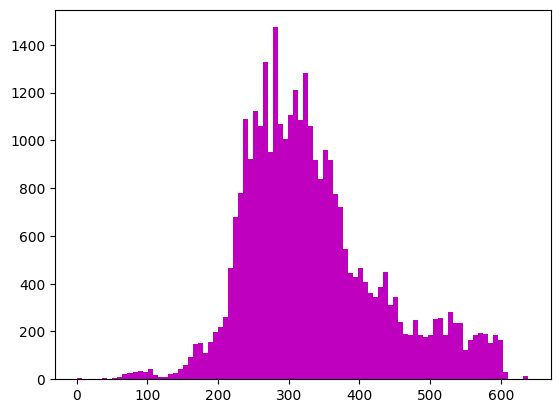

In [9]:
counts, bins, bars = plt.hist(date_nums_all, bins = 90, color = 'm')


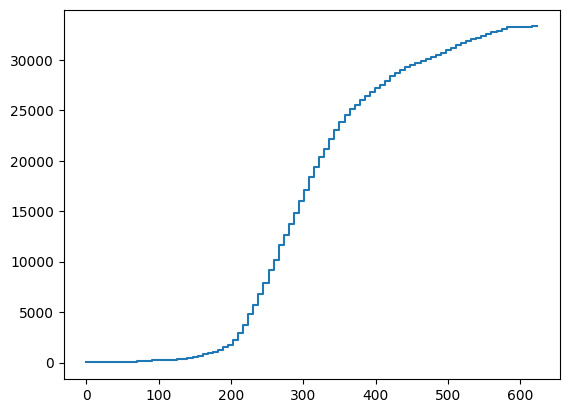

In [16]:

a = [counts[0]]
for i in range(0,89):
    a.append(a[i] + counts[i+1])

plt.step(range(0,630,7), a)

In [5]:
def daily_frequency(event_times):
    counter = Counter(event_times)
    keys = counter.keys()
    values = [counter[key] for key in keys]
    plt.bar(keys, values)
    plt.xlabel('Time (days)')
    plt.ylabel('Daily cases')

daily_frequency(date_nums_guinea)


TypeError: hist() got multiple values for argument 'bins'

In [7]:
def distribute(data):
    """Distribute cases in the same day evenly

    Args:
        data (List(int)): A list of event times

    Returns:
        List: Distributed event times
    """
    counter = Counter(data)
    sorted_elements = sorted(counter.keys())
    time_ticks = []
    for e in sorted_elements:
        count = counter[e]
        for n in range(count):
            time_ticks.append(int(e)-1+(n+1)/count)
        
    return time_ticks

In [8]:
observed_guinea = distribute(date_nums_guinea)
observed_liberia = distribute(date_nums_liberia)
observed_sierra = distribute(date_nums_sierra)
print(date_nums_guinea)
print(observed_guinea)

[1, 1, 6, 6, 11, 15, 20, 25, 29, 32, 33, 34, 34, 35, 35, 38, 40, 42, 47, 48, 49, 50, 52, 52, 54, 55, 55, 56, 56, 58, 58, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 62, 62, 64, 65, 66, 66, 66, 66, 67, 68, 69, 69, 69, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 73, 73, 73, 73, 74, 74, 74, 74, 75, 75, 75, 76, 77, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 81, 81, 81, 82, 82, 82, 82, 83, 83, 83, 83, 83, 83, 84, 84, 84, 84, 84, 84, 85, 85, 85, 86, 86, 86, 87, 87, 88, 88, 88, 88, 88, 89, 89, 89, 89, 89, 89, 89, 89, 91, 91, 91, 92, 93, 93, 93, 95, 96, 96, 96, 96, 96, 96, 97, 97, 97, 97, 98, 98, 98, 98, 98, 98, 98, 98, 98, 99, 99, 99, 99, 99, 99, 99, 100, 100, 100, 100, 100, 101, 101, 102, 102, 103, 103, 104, 104, 104, 105, 105, 107, 107, 108, 108, 108, 108, 109, 111, 112, 112, 113, 113, 114, 116, 116, 116, 117, 121, 122, 122, 122, 122, 123, 123, 123, 124, 125, 125, 125, 125, 126, 126, 127, 127, 128, 128, 128, 128, 129, 130, 130, 131, 131, 132, 134

## The Intensity Function

In [9]:
def binary_search(sorted_list, new):
    """Find the right position for a insertion"""
    left = 0
    right = len(sorted_list) - 1

    while left <= right:
        mid = (left + right) // 2
        if sorted_list[mid] == new:
            return mid
        elif sorted_list[mid] < new:
            left = mid + 1
        else:
            right = mid - 1
    return left

def history_n(t, event_times, n=50):
    """Reduce computations by ignoring all event times more than n days ago.
    Args:
        t: time
        n: number of days up to time t
        event_times (Iterable): event times 
    Returns:
        Iterable: all event times within n days of t
    """
    start = binary_search(event_times, t-n)
    end = binary_search(event_times,t)
    history_reduced = event_times[start:end]
    return history_reduced

In [10]:
def exponential_kernel(t, t_i, alpha, delta):
    return alpha*np.exp(-delta*(t-(t_i)))

def self_exciting_term(t, history, alpha, delta, dep=50):
    phi_sum = 0
    for t_i in history_n(t, history, dep):
        phi_sum += exponential_kernel(t, t_i, alpha, delta)
    return phi_sum

def intensity(t, history, alpha, delta, mu, dep=50):
    return mu + self_exciting_term(t, history, alpha, delta, dep)

Text(0.5, 1.0, 'Exponential kernel')

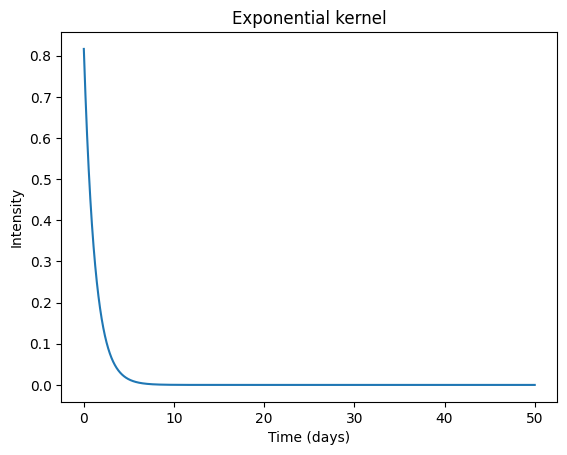

In [11]:
time50 = np.linspace(0,50,10000)
kernel_intensity = [exponential_kernel(t, 0, 0.81649203, 0.8209825) for t in time50]
plt.plot(time50, kernel_intensity)
plt.xlabel("Time (days)")
plt.ylabel("Intensity")
plt.title("Exponential kernel")

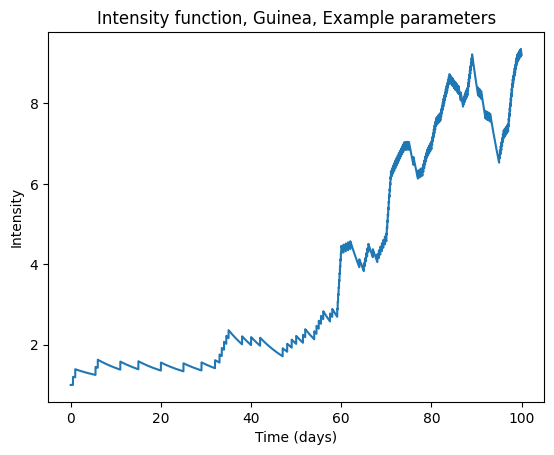

In [12]:
def intensity_plot(T, parameters):
    alpha, delta, mu = parameters
    time = np.arange(0,T,0.01)
    kernel_intensity = [intensity(t, observed_guinea, alpha, delta, mu) for t in time]
    plt.plot(time, kernel_intensity)
    plt.xlabel("Time (days)")
    plt.ylabel("Intensity")
    plt.title("Intensity function, Guinea, Example parameters")
example_parameters = [0.2,0.1, 1]
intensity_plot(100, example_parameters)

## MLE Estimation

In [13]:
def loglikelihood_terms(parameters, event_times, T):
    #Get event times up to T
    def event_times_small(event_times, T):
        end = binary_search(event_times,T)
        return event_times[:end]
    event_times_t = event_times_small(event_times, T)

    #Integral term of log likelihood
    def integral_slices(parameters, events):
        alpha, delta, mu = parameters
        integral_slices = []
        integral_intervals = [0] + events + [T]
        for ind in range(len(integral_intervals)-1):
            i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])
            integral_slices.append(i[0])
        return integral_slices

    integral_slices_t = integral_slices(parameters, event_times_t)

    #log term of log likelihood
    def log_term(parameters, events):
        alpha, delta, mu = parameters
        log_terms = []
        for t_i in events:
            log_terms.append(np.log(intensity(t_i, event_times_t, alpha, delta, mu)))
        return log_terms
    log_terms_t = log_term(parameters, event_times_t)

    return integral_slices_t, log_terms_t
        
example_parameters = [0.2,0.1,1]
y2, y3  = loglikelihood_terms(example_parameters, observed_guinea, 100)
print(y2)
print(y3)
print(np.sum(y2))
print(np.sum(y3))

[0.5, 0.5975411509985721, 5.914141226332616, 0.7188978334811453, 7.466824468436233, 5.912999358219149, 7.317375437936717, 7.192497933748342, 5.773586696091546, 4.453008276302867, 1.5855475113262167, 0.8690752369615127, 0.9486163762509361, 1.0242782484013457, 1.0962500475036265, 6.532481827089792, 4.192792032403807, 4.157844765877403, 9.621785922441981, 1.8683067586890472, 1.9760016095234514, 2.0734479402882213, 3.19835622450288, 1.1087246381566993, 4.514687843884905, 1.151476315883021, 1.2172445920318236, 1.2798053115032526, 1.338657681576753, 4.0551510336419465, 1.3675647522925305, 3.0709355938927643, 0.28855755867959804, 0.30658171212452756, 0.3244265222461929, 0.3420937735404112, 0.3595852327470572, 0.3769026490266271, 0.39404775413515275, 0.41102226259751634, 0.427827871878625, 2.1883956952392105, 2.2035928165104495, 2.217391538325699, 2.2311745156425222, 8.483115640071327, 3.9768759215040936, 0.9979034669155166, 1.0288178404663924, 1.0589689354147078, 1.0883755971763072, 4.3418798

In [14]:
def llh_neg(parameters, event_times, T):
    integral_slices_t, log_terms_t = loglikelihood_terms(parameters, event_times, T)
    integral_term = np.sum(integral_slices_t)
    log_sum = np.sum(log_terms_t)
    #print(integral_term)
    #print(log_sum)
    return integral_term - log_sum

llh_neg(example_parameters, observed_guinea, 300)

C:\Users\akhma\AppData\Local\Temp\ipykernel_17116\3844760165.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])


-1387.1774155888443

In [15]:
def con1(x):
    alpha, delta, mu = x
    return alpha
def con2(x):
    alpha, delta, mu = x
    return delta
cons = [{'type': 'ineq', 'fun': con1}, {'type': 'ineq', 'fun': con2} ]
result = opt.minimize(llh_neg, example_parameters, (observed_guinea,100), constraints=cons)

optimized_params = result.x

print(optimized_params)

C:\Users\akhma\AppData\Local\Temp\ipykernel_17116\3844760165.py:25: RuntimeWarning: invalid value encountered in log
  log_terms.append(np.log(intensity(t_i, event_times_t, alpha, delta, mu)))


[0.13399352 0.12191662 0.20635716]


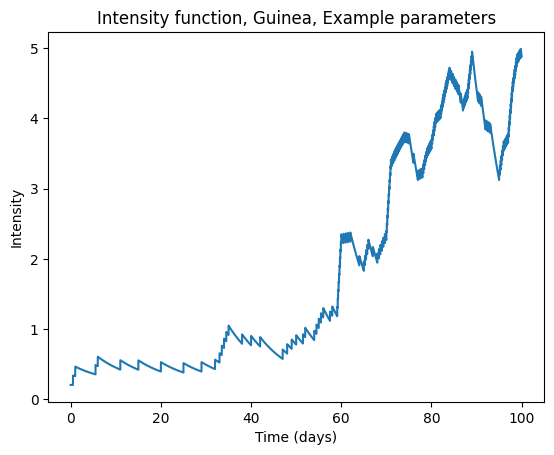

In [16]:
intensity_plot(100, optimized_params)

In [17]:
result600 = opt.minimize(llh_neg, example_parameters, (observed_guinea,600), constraints=cons)

optimized_params = result.x

print(optimized_params)

C:\Users\akhma\AppData\Local\Temp\ipykernel_17116\3844760165.py:14: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  i = spi.quad(lambda t: intensity(t, event_times_t, alpha, delta, mu), integral_intervals[ind], integral_intervals[ind+1])


KeyboardInterrupt: 

These are the event times up to time T, broken into chunks of less than 50 events: [array([ 0.5 ,  1.  ,  5.5 ,  6.  , 11.  , 15.  , 20.  , 25.  , 29.  ,
       32.  , 33.  , 33.5 , 34.  , 34.5 , 35.  , 38.  , 40.  , 42.  ,
       47.  , 48.  , 49.  , 50.  , 51.5 , 52.  , 54.  , 54.5 , 55.  ,
       55.5 , 56.  , 57.5 , 58.  , 59.1 , 59.2 , 59.3 , 59.4 , 59.5 ,
       59.6 , 59.7 , 59.8 , 59.9 , 60.  , 60.5 , 61.  , 61.5 , 62.  ,
       64.  , 65.  , 65.25, 65.5 ]), array([65.75      , 66.        , 67.        , 68.        , 68.33333333,
       68.66666667, 69.        , 69.33333333, 69.66666667, 70.        ,
       70.1       , 70.2       , 70.3       , 70.4       , 70.5       ,
       70.6       , 70.7       , 70.8       , 70.9       , 71.        ,
       71.25      , 71.5       , 71.75      , 72.        , 72.25      ,
       72.5       , 72.75      , 73.        , 73.25      , 73.5       ,
       73.75      , 74.        , 74.33333333, 74.66666667, 75.        ,
       76.        , 77.  

TypeError: object of type 'numpy.float64' has no len()

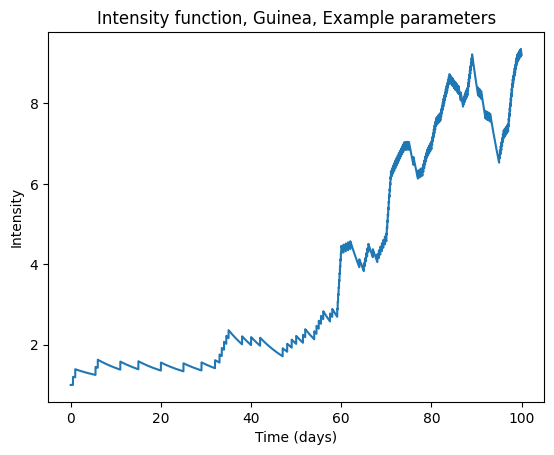

In [ ]:
def loglikelihood_terms(parameters, event_times, T):
    def event_times_split(event_times, T):
            end = binary_search(event_times,T)
            event_times_T = np.array(event_times[:end])  # Get event times up to T
            split_times = np.split(event_times_T, np.arange(49, len(event_times_T), 49)) # Split event times into chunks of at most 50
            split_ends = [0] + [chunk[-1] for chunk in split_times]
            return event_times_T, split_times, split_ends

    event_times_T, event_times_50, integration_ends = event_times_split(event_times, T)
    #print(f"These are the event times up to time T: {event_times_T}")
    print(f"These are the event times up to time T, broken into chunks of less than 50 events: {event_times_50}. "
        f"and the lengths of each chunk are: {[len(chunk) for chunk in event_times_50]}")
    print(f"These are the boundaries between chunks: {integration_ends}")

    intensity_plot(T, parameters)

    alpha, delta, mu = parameters
    integral_slices = []
    for i in range(len(integration_ends)-1):
        integral_slices.append(spi.quad(lambda t: intensity(t, event_times_T[i], alpha, delta, mu),
                                        integration_ends[i], integration_ends[i+1], points = event_times_50[i])[0])
    print(f"These are the integrals of each chunk: {integral_slices}")

    log_terms = []
    for t_i in event_times_T:
        log_terms.append(np.log(intensity(t_i, event_times_T, alpha, delta, mu)))
    print(f"These are the log_terms {log_terms}")

    integral_term = np.sum(integral_slices)
    log_term = np.sum(log_terms)

    return integral_term, log_term

example_parameters = [0.2,0.1,1]
y2, y3  = loglikelihood_terms(example_parameters, observed_guinea, 100)
print(f"The integral term is {y2}")
print(f"The log sum is: {y3}")

These are the event times up to time T: [ 0.5  1.   5.5  6.  11.  15. ]
These are the event times up to time T, broken into chunks of less than 50 events: [array([0.5, 1. ]), array([5.5, 6. ]), array([11., 15.])]. and the lengths of each chunk are: [2, 2, 2]
These are the bounds for the integration: [0, 3.25, 8.5, 20]
[11. 15.]
Integrating between (8.5, 20)
Discontinuities at [11. 15.]
Integrate intensity function between (8.5, 20) gives 16.81040851662715


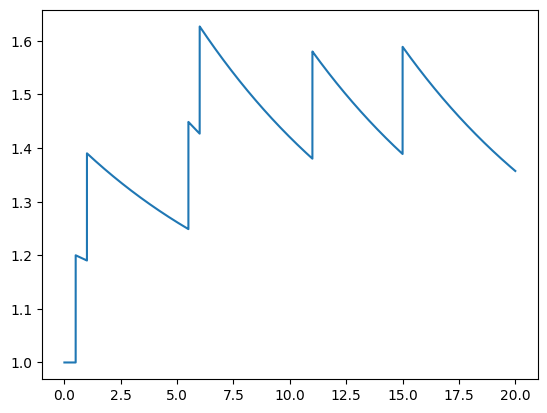

In [ ]:
def event_times_split(event_times, T):
      end = binary_search(event_times,T)
      event_times_T = np.array(event_times[:end])  # Get event times up to T
      split_times = np.split(event_times_T, np.arange(2, len(event_times_T), 2)) # Split event times into chunks of at most 50
      chunk_end = [split_times[i][-1] for i in range(len(split_times)-1)]
      chunk_beg = [split_times[i][0] for i in range(1, len(split_times))]
      integration_ends = [0] + [np.mean(pair) for pair in zip(chunk_end, chunk_beg)] + [T]
      return event_times_T, split_times, integration_ends

event_times_T, event_times_50, bounds = event_times_split(observed_guinea, 20)
print(f"These are the event times up to time T: {event_times_T}")
print(f"These are the event times up to time T, broken into chunks of less than 50 events: {event_times_50}. "
      f"and the lengths of each chunk are: {[len(chunk) for chunk in event_times_50]}")
print(f"These are the bounds for the integration: {bounds}")
alpha, delta, mu = [0.2, 0.1, 1]
print(event_times_50[2])
time = np.arange(0, 20, 0.001)

print(f"Integrating between {bounds[2], bounds[2+1]}")
print(f"Discontinuities at {event_times_50[2]}")
integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),
                  bounds[2], bounds[2+1], points = event_times_50[2])[0]
plt.plot(time, [intensity(t, event_times_T, alpha, delta, mu) for t in time])
print(f"Integrate intensity function between {bounds[2], bounds[2+1]} " 
      f"gives {integral}")

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\2956374549.py:22: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),


Integration took 41.51 seconds
These are the integral slices: [131.18622992544994, 84.62779014602508, 104.15513211984401, 118.61887138729519, 139.9007225695077, 69.3347214266971, 100.85368583280618, 119.1756179422481, 160.86890355984318, 108.5634154289289, 82.83649954487193, 48.91187627356216, 72.01927992240428, 40.19140094233578, 91.35249031137107, 74.63656493444081, 100.6820797076709, 70.63713256508609, 118.36091369077086, 91.41570782288343, 121.27532944554964, 98.60030462919191, 90.61450029575522, 97.01926085283931, 100.61557016130081, 66.20962582164205, 79.47910839411763, 91.85752852505335, 107.10943760873434, 92.01527216561111, 109.50403052159122, 127.98146648493142, 118.71457853037784, 114.20490598154689, 78.60027349146934, 69.03394990820084, 51.094467717821516, 70.97020160789647, 163.13504765084232, 100.59358089281463, 80.57824256358764, 98.03944578954196, 78.09669604947213, 103.58247765329887, 158.4362148781538, 109.21478191605084, 94.54978643445658, 68.09711857006405, 121.7919

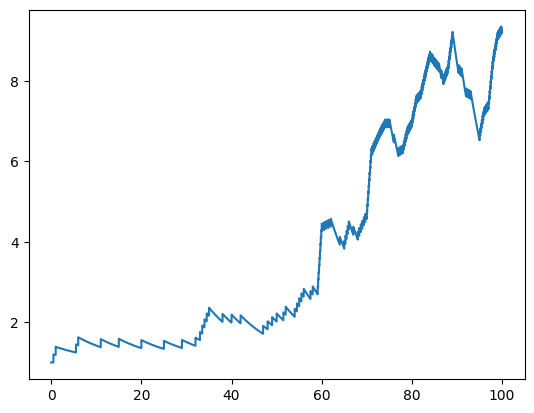

In [ ]:
import time
def event_times_split(event_times, T):
      end = binary_search(event_times,T)
      event_times_T = np.array(event_times[:end])  # Get event times up to T
      split_times = np.split(event_times_T, np.arange(49, len(event_times_T), 49)) # Split event times into chunks of less than 50
      chunk_end = [split_times[i][-1] for i in range(len(split_times)-1)]
      chunk_beg = [split_times[i][0] for i in range(1, len(split_times))]
      integration_ends = [0] + [np.mean(pair) for pair in zip(chunk_end, chunk_beg)] + [T]
      return event_times_T, split_times, integration_ends

event_times_T, event_times_50, bounds = event_times_split(observed_guinea, 600)
#print(f"These are the event times up to time T: {event_times_T}")
#print(f"These are the event times up to time T, broken into chunks of less than 50 events: {event_times_50}. "
      #f"and the lengths of each chunk are: {[len(chunk) for chunk in event_times_50]}")
#print(f"These are the bounds for the integration: {bounds}")
alpha, delta, mu = [0.2, 0.1, 1]
start_time = time.time()
integral_slices = []
for i in range(len(bounds)-1):
      #print(event_times_50[i])
      #print(f"Discontinuities at {event_times_50[i]}")
      integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),
                        bounds[i], bounds[i+1], points = event_times_50[i])[0]
      #print(f"Integrate intensity function between {bounds[i], bounds[i+1]} " 
            #f"gives {integral}")
      integral_slices.append(integral)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Integration took {elapsed_time:.2f} seconds")
#time = np.arange(0, 100, 0.01)
#plt.plot(time, [intensity(t, event_times_T, alpha, delta, mu) for t in time])
print(f"These are the integral slices: {integral_slices}")

In [ ]:
integral_term = np.sum(integral_slices)
print(f"This is the integral_term: {integral_term}")

log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]
print(f"These are the log terms: {log_terms}")
log_term = np.sum(log_terms)
print(f"This is the integral term: {log_term}")

This is the integral_term: 8023.74058344397
These are the log terms: [0.0, 0.1741599117457398, 0.222208524126007, 0.3555336781857864, 0.32227154820790305, 0.32855497497852626, 0.30544000229251167, 0.2911552283705665, 0.30793576673398565, 0.3473505397771889, 0.442605460549804, 0.542237360893872, 0.6286027124134455, 0.7043645423266073, 0.7714665671533776, 0.6979794050805412, 0.6883399613002796, 0.6803780801241338, 0.5379225037991734, 0.601916855849819, 0.6564908352662142, 0.7034291070082008, 0.716931640865627, 0.7826526680079804, 0.758840293360335, 0.8200662455949744, 0.8750210512924398, 0.9246339354645711, 0.9691609063147402, 0.9473510131092725, 0.9903262895173717, 0.9914053204149073, 1.0564572609028904, 1.1169449638109241, 1.1734298609216347, 1.2263759359585187, 1.2761710485244444, 1.3231427266095528, 1.3675700648995543, 1.4096928272306408, 1.4497185062905313, 1.4570032767699561, 1.4638838605127817, 1.470090565539957, 1.4762519682872544, 1.3681813143883745, 1.3429985911111952, 1.374822

In [ ]:
import time  
def llh_neg(parameters, event_times, T):
      def event_times_split(event_times, T):
            end = binary_search(event_times,T)
            event_times_T = np.array(event_times[:end])  # Get event times up to T
            split_times = np.split(event_times_T, np.arange(49, len(event_times_T), 49)) # Split event times into chunks of less than 50
            chunk_end = [split_times[i][-1] for i in range(len(split_times)-1)]
            chunk_beg = [split_times[i][0] for i in range(1, len(split_times))]
            integration_ends = [0] + [np.mean(pair) for pair in zip(chunk_end, chunk_beg)] + [T]
            return event_times_T, split_times, integration_ends

      event_times_T, event_times_50, bounds = event_times_split(event_times, T)
      #print(f"These are the event times up to time T: {event_times_T}")
      #print(f"These are the event times up to time T, broken into chunks of less than 50 events: {event_times_50}. "
            #f"and the lengths of each chunk are: {[len(chunk) for chunk in event_times_50]}")
      #print(f"These are the bounds for the integration: {bounds}")
      alpha, delta, mu = parameters
      start_time = time.time()
      integral_slices = []
      for i in range(len(bounds)-1):
            #print(event_times_50[i])
            #print(f"Discontinuities at {event_times_50[i]}")
            integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),
                              bounds[i], bounds[i+1], points = event_times_50[i])[0]
            #print(f"Integrate intensity function between {bounds[i], bounds[i+1]} " 
                  #f"gives {integral}")
            integral_slices.append(integral)
      end_time = time.time()
      elapsed_time = end_time - start_time
      print(f"Integration took {elapsed_time:.2f} seconds")
      #time = np.arange(0, 100, 0.01)
      #plt.plot(time, [intensity(t, event_times_T, alpha, delta, mu) for t in time])
      #print(f"These are the integral slices: {integral_slices}")
      integral_term = np.sum(integral_slices)
      print(f"This is the integral_term: {integral_term}")

      log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]
      #print(f"These are the log terms: {log_terms}")
      log_term = np.sum(log_terms)
      print(f"This is the log term: {log_term}")
      
      return integral_term - log_term

In [ ]:
example_parameters = [0.2, 0.1, 1]
llh_neg(example_parameters, observed_guinea, 300)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),


Integration took 15.22 seconds
This is the integral_term: 3364.1438034706157
This is the log term: 4751.320107135872


-1387.176303665256

In [ ]:
def con1(x):
    return x[0]  # alpha > 0
def con2(x):
    return x[1]  # delta > 0
def con3(x):
    return x[2]  # mu > 0
cons = [
    {'type': 'ineq', 'fun': con1},
    {'type': 'ineq', 'fun': con2},
    {'type': 'ineq', 'fun': con3}
]
example_parameters = [0.5,0.5,1]
result = opt.minimize(llh_neg, example_parameters, args=(observed_guinea,100), constraints=cons)

optimized_params100 = result.x

print(optimized_params100)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),


Integration took 0.32 seconds
This is the integral_term: 268.0584526222708
This is the log term: 231.75171477884214
Integration took 0.31 seconds
This is the integral_term: 268.058457630803
This is the log term: 231.7517184154739
Integration took 0.32 seconds
This is the integral_term: 268.05844791342855
This is the log term: 231.75171136886343
Integration took 0.30 seconds
This is the integral_term: 268.058454112387
This is the log term: 231.75171562783416
Integration took 0.34 seconds
This is the integral_term: 1.5475717002411523e-09
This is the log term: -4463.770778752743
Integration took 0.33 seconds
This is the integral_term: 70.4440285970021
This is the log term: -67.18638302989635
Integration took 0.31 seconds
This is the integral_term: 90.2750269422905
This is the log term: -21.86017037791556
Integration took 0.31 seconds
This is the integral_term: 105.16397973133938
This is the log term: 13.519790368115828
Integration took 0.30 seconds
This is the integral_term: 122.583079384

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:37: RuntimeWarning: invalid value encountered in log
  log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]


Integration took 0.30 seconds
This is the integral_term: 189.16646206029617
This is the log term: 161.9716179157038
Integration took 0.30 seconds
This is the integral_term: 189.16646379354617
This is the log term: 161.97161971222567
Integration took 0.30 seconds
This is the integral_term: 189.16646106900419
This is the log term: 161.97161678483988
Integration took 0.30 seconds
This is the integral_term: 189.1664635504122
This is the log term: 161.97161916511075
Integration took 0.30 seconds
This is the integral_term: 183.2584412456046
This is the log term: 169.4725734224068
Integration took 0.30 seconds
This is the integral_term: 183.2584504353314
This is the log term: 169.47258234353495
Integration took 0.30 seconds
This is the integral_term: 183.25843264119425
This is the log term: 169.4725649956216
Integration took 0.30 seconds
This is the integral_term: 183.25844273572065
This is the log term: 169.4725749605072
Integration took 0.30 seconds
This is the integral_term: 147.3767072871

In [ ]:
result = opt.minimize(llh_neg, example_parameters, args=(observed_guinea,300), constraints=cons)

optimized_params300 = result.x

print(optimized_params300)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),


Integration took 14.10 seconds
This is the integral_term: 1948.823846827623
This is the log term: 3852.2103952783627
Integration took 13.95 seconds
This is the integral_term: 1948.8238959664027
This is the log term: 3852.2104385552393
Integration took 13.87 seconds
This is the integral_term: 1948.823798447862
This is the log term: 3852.2103526503515
Integration took 13.92 seconds
This is the integral_term: 1948.823851297971
This is the log term: 3852.2103986291713
Integration took 16.52 seconds
This is the integral_term: 3.7226767247965095e-07
This is the log term: -34513.85852571187
Integration took 16.40 seconds
This is the integral_term: 182.63981853751227
This is the log term: -861.7111933842148
Integration took 16.07 seconds
This is the integral_term: 251.64042721262268
This is the log term: -346.8237319317139
Integration took 15.24 seconds
This is the integral_term: 295.74387896419523
This is the log term: -73.024988426882
Integration took 14.14 seconds
This is the integral_term:

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:37: RuntimeWarning: invalid value encountered in log
  log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]


This is the log term: nan
Integration took 14.24 seconds
This is the integral_term: 1787.968853687598
This is the log term: 3620.710486865776
Integration took 14.02 seconds
This is the integral_term: 1693.2245233633018
This is the log term: 3604.769048875917
Integration took 14.09 seconds
This is the integral_term: 1655.3357259690397
This is the log term: 3569.0539874801916
Integration took 14.10 seconds
This is the integral_term: 1655.335760385601
This is the log term: 3569.0540233956312
Integration took 14.11 seconds
This is the integral_term: 1655.3356980899864
This is the log term: 3569.0539581049497
Integration took 14.42 seconds
This is the integral_term: 1655.3357304393883
This is the log term: 3569.053991389516
Integration took 15.08 seconds
This is the integral_term: 1579.2388198161052
This is the log term: nan
Integration took 13.97 seconds
This is the integral_term: 1641.360613244492
This is the log term: 3559.7001699634206
Integration took 14.02 seconds
This is the integral

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:37: RuntimeWarning: divide by zero encountered in log
  log_terms = [np.log(intensity(t_i, event_times_T, alpha, delta, mu)) for t_i in event_times_T]


This is the log term: -inf
Integration took 14.37 seconds
This is the integral_term: 1666.4224692137914
This is the log term: 3597.6118149839695
Integration took 14.31 seconds
This is the integral_term: 1666.4225157518163
This is the log term: 3597.6118624202945
Integration took 14.55 seconds
This is the integral_term: 1666.4224283453148
This is the log term: 3597.611773200802
Integration took 14.28 seconds
This is the integral_term: 1666.4224736841397
This is the log term: 3597.6118190474967
Integration took 14.38 seconds
This is the integral_term: 1825.8234419677035
This is the log term: 3717.9923166319736
Integration took 14.04 seconds
This is the integral_term: 1671.3139377380967
This is the log term: 3606.4679538678365
Integration took 14.10 seconds
This is the integral_term: 1671.3139883512913
This is the log term: 3606.4680050508127
Integration took 14.21 seconds
This is the integral_term: 1671.313892024751
This is the log term: 3606.467907551109
Integration took 14.04 seconds
T

In [ ]:
result = opt.minimize(llh_neg, [0.38634904, 0.39707437, 0.26378802], args=(observed_guinea,600), constraints=cons)

optimized_params600 = result.x

print(optimized_params600)

C:\Users\akhma\AppData\Local\Temp\ipykernel_34208\4238488812.py:23: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integral = spi.quad(lambda t: intensity(t, event_times_T, alpha, delta, mu),


Integration took 41.32 seconds
This is the integral_term: 3797.4235347625927
This is the log term: 8490.297899481015
Integration took 40.77 seconds
This is the integral_term: 3797.42367512161
This is the log term: 8490.298037835913
Integration took 40.87 seconds
This is the integral_term: 3797.4233982320316
This is the log term: 8490.297765599464
Integration took 41.13 seconds
This is the integral_term: 3797.42354370329
This is the log term: 8490.29790816966
Integration took 47.96 seconds
This is the integral_term: 3.3709345079321335e-08
This is the log term: -89216.18538550334
Integration took 43.87 seconds
This is the integral_term: 193.7017648709416
This is the log term: -4322.43900971149
Integration took 41.14 seconds
This is the integral_term: 529.8316017095706
This is the log term: 698.0721579804324
Integration took 40.98 seconds
This is the integral_term: 2118.156373296523
This is the log term: 6297.61644310073
Integration took 41.12 seconds
This is the integral_term: 3510.73171

In [ ]:
def exact_integral(parameters, events, T):
    alpha, delta, mu = parameters
    sum = 0
    for t_i in events:
        sum += alpha * np.exp(delta * t_i) * (1/delta) * (np.exp(-delta * t_i) - np.exp(-delta * T))
    return mu * T + sum

example_parameters = [0.2, 0.1, 1]
def event_times_small(event_times, T):
    end = binary_search(event_times,T)
    return event_times[:end]
event_times_600 = event_times_small(observed_guinea, 600)
print(event_times_600)
exact_integral(example_parameters, event_times_600, 600)

[0.5, 1.0, 5.5, 6.0, 11.0, 15.0, 20.0, 25.0, 29.0, 32.0, 33.0, 33.5, 34.0, 34.5, 35.0, 38.0, 40.0, 42.0, 47.0, 48.0, 49.0, 50.0, 51.5, 52.0, 54.0, 54.5, 55.0, 55.5, 56.0, 57.5, 58.0, 59.1, 59.2, 59.3, 59.4, 59.5, 59.6, 59.7, 59.8, 59.9, 60.0, 60.5, 61.0, 61.5, 62.0, 64.0, 65.0, 65.25, 65.5, 65.75, 66.0, 67.0, 68.0, 68.33333333333333, 68.66666666666667, 69.0, 69.33333333333333, 69.66666666666667, 70.0, 70.1, 70.2, 70.3, 70.4, 70.5, 70.6, 70.7, 70.8, 70.9, 71.0, 71.25, 71.5, 71.75, 72.0, 72.25, 72.5, 72.75, 73.0, 73.25, 73.5, 73.75, 74.0, 74.33333333333333, 74.66666666666667, 75.0, 76.0, 77.0, 77.33333333333333, 77.66666666666667, 78.0, 78.2, 78.4, 78.6, 78.8, 79.0, 79.25, 79.5, 79.75, 80.0, 80.16666666666667, 80.33333333333333, 80.5, 80.66666666666667, 80.83333333333333, 81.0, 81.25, 81.5, 81.75, 82.0, 82.16666666666667, 82.33333333333333, 82.5, 82.66666666666667, 82.83333333333333, 83.0, 83.16666666666667, 83.33333333333333, 83.5, 83.66666666666667, 83.83333333333333, 84.0, 84.33333333

8073.295152707334

## Simulation - Thinning algorithm

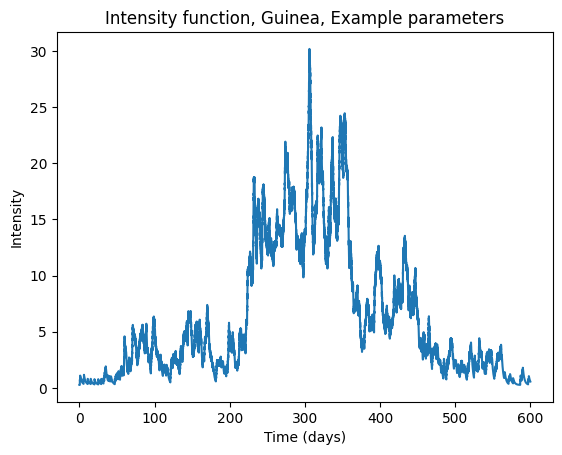

In [ ]:
intensity_plot(600, [0.4672532, 0.48739678, 0.25877342])

In [ ]:
def simulate_hawkes_process(alpha, delta, mu, n):
    """simulate hawkes process from a given intensity function

    Args:
        n (int): iterations

    Returns:
        List(int): event times
    """
    event_times = []
    T = 0.0
    i = 0

    while i < n:
        lambda_star = intensity(T, event_times, alpha, delta, mu)
        if lambda_star == 0:
            print(T)
        u = np.random.uniform(0, 1)
        tau = -np.log(u) / lambda_star
        T += tau
        s = np.random.uniform(0, 1)

        if s <= intensity(T, event_times, alpha, delta, mu)/lambda_star:
            event_times.append(T)
            i += 1

    return event_times

n = 2000
event_times_sim = simulate_hawkes_process(0.4672532, 0.48739678, 0.25877342, n)
print(event_times_sim)
daily_cases_sim = np.floor(event_times_sim)
print(daily_cases_sim)
daily_frequency(daily_cases_sim)

NameError: name 'intensity' is not defined